# Experiments on Version 2
## of Adaptive Dropout Probabilities via Tsetlin Machine-inspired Majority Voting

In this notebook I introduce the new version, and continue experiments on "tsetlin" dropout.

For background and history, check out the notebook titled "Initial Experiments". 

Version 2! This version addresses some of the problems that the first draft had, namely speed and variance. As a refresher, the initial version assigned each unit/input an individual dropout probability that was updated after each gradient update. The probability of being included in the network would decrease as the network's accuracy increased, and vice-versa. Specifically, for each classification in a batch, the probabilities of the units that were used in the classification were updated by the following formulae:

$$
{p}_{t+1} = p_{t} - \alpha (p_{t}-1)*exp(-p_{t})  
$$

For incorrect classification, and:

$$
{p}_{t+1} = p_{t} - \alpha (p_{t})*exp(p_{t}-1) 
$$

for correct classification. This remains true for version 2, however instead of updating the probabilites for every classification in the batch, version 2 counts the number of correct vs incorrect classifications, and updates the probabilities once in the direction of the majority. This reduces computation and variance while keeping the spirit of the original version. The key philosophy is to adapt the dropout probabilities w.r.t network performance, and this version still does that! If I really wanted to lean into the Tsetlin Machine inspiriation, I could add hyperparameter that changes the threshold from simple majority to some other ratio, but for now, let's look at this version. 

In code, it looks like this:

Note the addition of the clipping (torch.clamp) option. This is fun to play with, and will be explored further. 

In [3]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt


class TsetlinUnitDropout(nn.Module): 
    def __init__(self, in_size, init_prob, step_discount, clip=False, clip_min=None, clip_max=None):
        super().__init__()
        assert 0 <= init_prob < 1
        self.discount = step_discount
        self.pmin = clip_min
        self.pmax = clip_max
        self.clip = clip
        self.probabilities = torch.nn.Parameter(torch.tensor(np.full((1, in_size), init_prob, dtype="float32")),
                                                requires_grad=False)
        self.not_dropped = []  

    def forward(self, inp):
        assert inp.shape[1] == self.probabilities.shape[1]
        dev = self.probabilities.device
        comparator = torch.rand(inp.shape[1]).to(dev)
        mask = (comparator < self.probabilities).float().to(dev) # compares rand nums to probability of being
        # included
        # Assign not_dropped indices of prob tensor whose unit WAS included in network (These will be updated at step)
        self.not_dropped = mask.nonzero(as_tuple=True)  # To be indexed with
        return mask * inp / self.probabilities  # inverted dropout scaling

    def update_probs(self, correct_list):  # This implementation penalizes (increases dropout prob) if correct
            batch_size = len(correct_list)
            corr_distance = 2*correct_list.sum() - batch_size
            if corr_distance > 0: # decrease chance of inclusion (increase dropout prob) if correct
              self.probabilities[self.not_dropped] -=  (self.probabilities[self.not_dropped] * self.discount / torch.exp(
                    1 - self.probabilities[self.not_dropped]))

            elif corr_distance < 0:  # this number is negative (-= - = +) ie. increase chance of inclusion (decrease dropout prob)
                self.probabilities[self.not_dropped] -=  (self.discount * (self.probabilities[self.not_dropped] - 1) / torch.exp(
                    self.probabilities[self.not_dropped]))

            if self.clip:
              torch.clamp_(self.probabilities, self.pmin, self.pmax)

Along with the new version of "Tsetlin", I decided to change up my architecture to better emulate others' work. Specifically, Morerio et al.'s paper on Curriculum Dropout has been a major influence on my recent work. In their paper, they use a three-layer FNN with 2000 units each for the MNIST dataset. Additionally, they use a learning rate of 0.0001and a momentum of 0.95. I use these values unless stated otherwise. Here is a comparison of of my model, two controls, Curriculum dropout, and another hybrid model I will discuss later. This is the average of 20 runs over 10 epochs.

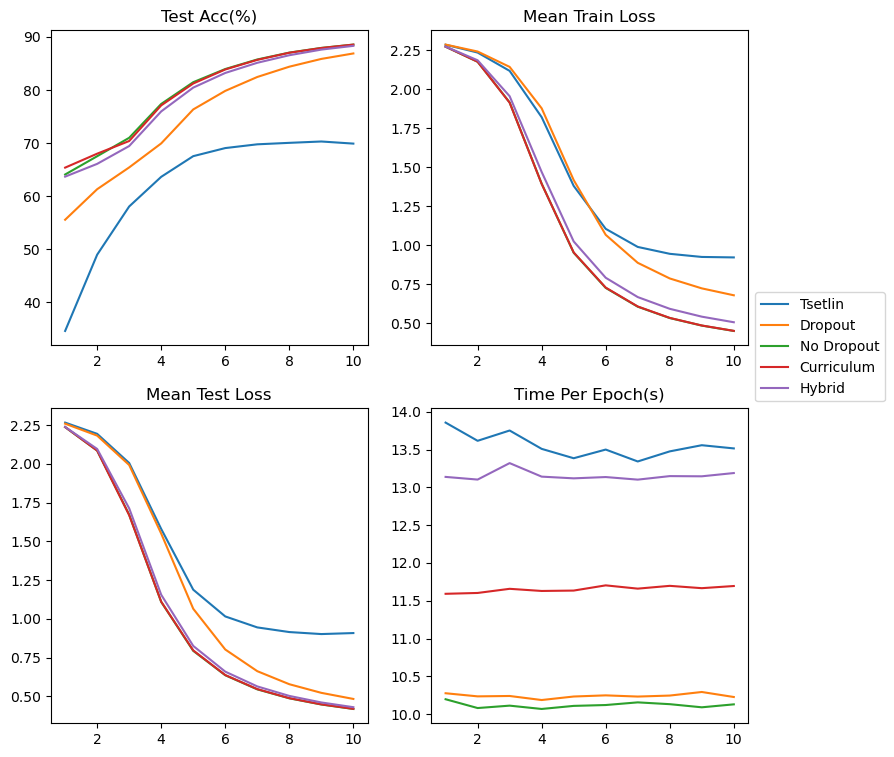

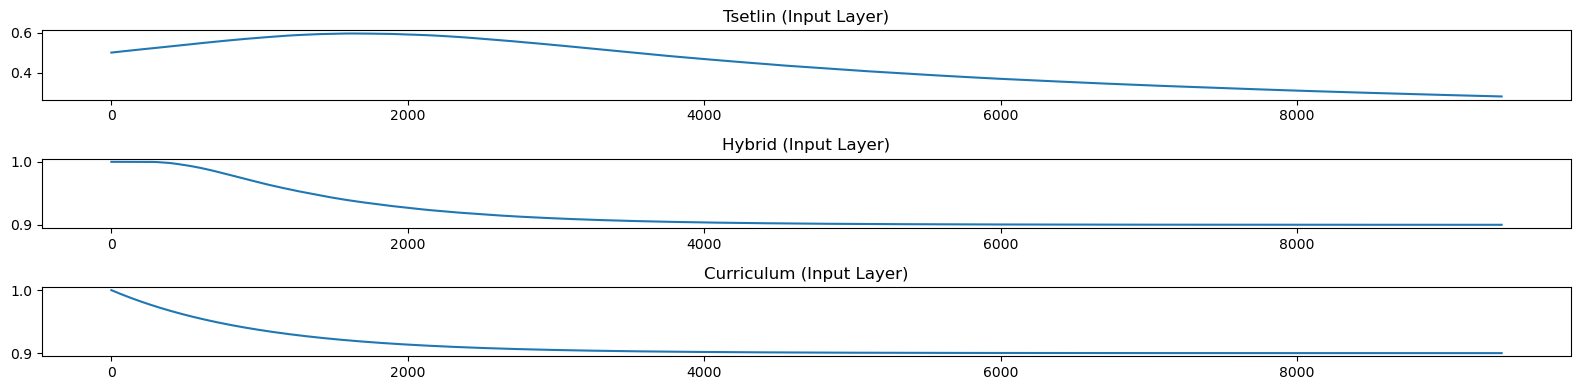

In [4]:
def get_avg(dataframe, column):
    descr = dataframe[column].describe()
    mini = int(descr[3])
    maxi = int(descr[-1])
    new_frame = pd.DataFrame({col:[dataframe[dataframe[column] == i][col].mean() for i in range(mini,maxi+1)] for col in dataframe.columns})
    
    return new_frame

tdf = pd.read_csv(r"MNIST\2000 Model\MNISTTsetlin20x10.csv")
ddf = pd.read_csv(r"MNIST\2000 Model\MNISTDrop20x10.csv")
ndf = pd.read_csv(r"MNIST\2000 Model\MNSITNoDrop20x10.csv")
cdf = pd.read_csv(r"MNIST\2000 Model\MNISTCurr20x10.csv")
hdf = pd.read_csv(r"MNIST\2000 Model\MNISTHybrid_20x10.csv")

tmean = get_avg(tdf,"Epoch")
dmean = get_avg(ddf,"Epoch")
nmean = get_avg(ndf,"Epoch")
cmean = get_avg(cdf,"Epoch")
hmean = get_avg(hdf,"Epoch")

x = np.arange(1,11)
fig,ax = plt.subplots(2,2,figsize=(9,9))

ax[0,0].plot(x,tmean['Test Acc(%)'],label="Tsetlin")
ax[0,0].plot(x,dmean['Test Acc(%)'],label="Dropout")
ax[0,0].plot(x,nmean['Test Acc(%)'],label="No Dropout")
ax[0,0].plot(x,cmean['Test Acc(%)'],label="Curriculum")
ax[0,0].plot(x,hmean['Test Acc(%)'],label="Hybrid")
ax[0,0].set_title("Test Acc(%)")

ax[0,1].plot(x,tmean["Mean Train Loss"],label="Tsetlin")
ax[0,1].plot(x,dmean["Mean Train Loss"],label="Dropout")
ax[0,1].plot(x,nmean["Mean Train Loss"],label="No Dropout")
ax[0,1].plot(x,cmean["Mean Train Loss"],label="Curriculum")
ax[0,1].plot(x,hmean["Mean Train Loss"],label="Hybrid")
ax[0,1].set_title("Mean Train Loss")

ax[1,0].plot(x,tmean["Mean Test Loss"],label="Tsetlin")
ax[1,0].plot(x,dmean['Mean Test Loss'],label="Dropout")
ax[1,0].plot(x,nmean['Mean Test Loss'],label="No Dropout")
ax[1,0].plot(x,cmean['Mean Test Loss'],label="Curriculum")
ax[1,0].plot(x,hmean['Mean Test Loss'],label="Hybrid")
ax[1,0].set_title("Mean Test Loss")


ax[1,1].plot(x,tmean["Time Per Epoch(s)"],label="Tsetlin")
ax[1,1].plot(x,dmean["Time Per Epoch(s)"],label="Dropout")
ax[1,1].plot(x,nmean["Time Per Epoch(s)"],label="No Dropout")
ax[1,1].plot(x,cmean["Time Per Epoch(s)"],label="Curriculum")
ax[1,1].plot(x,hmean["Time Per Epoch(s)"],label="Hybrid")
ax[1,1].set_title("Time Per Epoch(s)")

plt.legend(loc="lower left",bbox_to_anchor=(1,1))
plt.show()

hprobs = pd.read_csv(r"MNIST/2000 Model/MNISTHybrid_20x10_probs.csv")
tprobs = pd.read_csv(r"MNIST/2000 Model/MNISTTsetlin20x10_probs.csv")
temp = np.array([tprobs[tprobs.Run == i]["Keep Probability"] for i in range(20)])
tmean_prob = temp.mean(axis=0)
temp = np.array([hprobs[hprobs.Run == i]["Keep Probability"] for i in range(20)])
hmean_prob = temp.mean(axis=0)

cprobs = [(1-0.9)*np.exp(-0.001*i)+0.9 for i in range(1,len(tmean_prob)+1)]

f2,a2 = plt.subplots(3,1,figsize=(16,4))

a2[0].plot(np.arange(len(tmean_prob)), tmean_prob)
a2[0].set_title("Tsetlin (Input Layer)")
a2[1].plot(np.arange(len(hmean_prob)),hmean_prob)
a2[1].set_title("Hybrid (Input Layer)")
a2[2].plot(np.arange(len(hmean_prob)),cprobs)
a2[2].set_title("Curriculum (Input Layer)")
plt.tight_layout()

Once again at 10 Epochs the 'Tsetlin' dropout performs worse than all the other options. A possible explanation of which can be seen in the graph of the keep probability of the Input layer. Both Curriculum and the very similar Hybrid model use only a small dropout probability for the input layer, whereas by the end of 10 Epochs, the Tsetlin model allows less than half of the input vector into the model. I believe this is making it too difficult to accurately classify. For future models, this should be addressed by increasing the initial value of the input layer and potentially adding a floor.


### A Brief Aside on Batch Size

Because "Tsetlin" dropout is sensitive to the batch size, I did some cursory research on the effect of batch size in NN training. Most research agrees that the trade of is between accuracy and time, and that the learning rate must be adjusted to reflect different batch sizes. A larger size necessitates a larger learning rate. Morerio et al used a batch size of 128, which seemingly would suggest a larger learning rate, however they did not employ this. For my tests, I use a batch size of 64, which seems like the largest power of 2 that this learning rate does not significantly impact. You can see the change in shape of the graphs below. 

Here is a quick comparison of different batch sizes. All learning rates are 0.0001, and these are averages of 10 runs.  

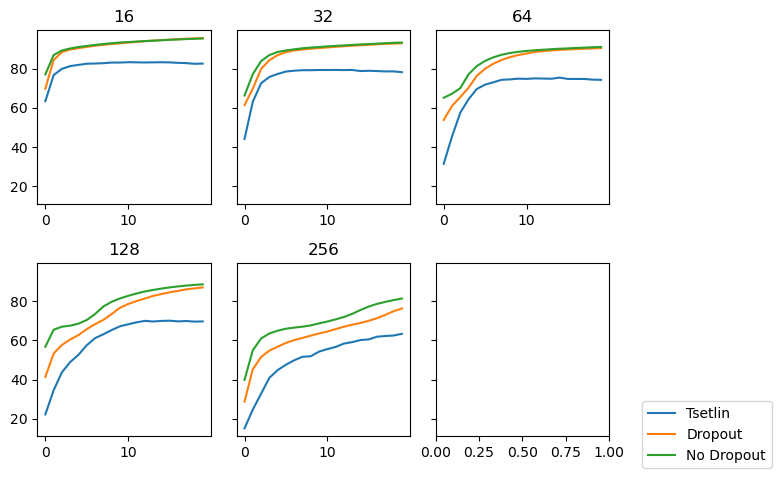

In [5]:
tset16 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\TsetlinBS_16_10x20.csv")
drop16 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\DropBS_16_10x20.csv")
nodrop16 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\MNISTnodrop_BS16_10x20.csv")


tset32 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\MNISTTsetlinBS32_10x20.csv")
drop32 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\DropBS_32_10x20.csv")
nodrop32 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\NoDropBS_32_20x10.csv")


tset64 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\MNISTTsetlinBS64_10x20.csv")
drop64 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\DropBS_64_10x20.csv")
nodrop64 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\NoDropBS_64_10x20.csv")


tset128 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\MNISTTsetlinBS128_10x20.csv")
drop128 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\DropBS_128_10x20.csv")
nodrop128 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\MNISTnodrop_BS128_10x20.csv")


tset256 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\TsetlinBS_256_10x20.csv")
drop256 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\DropBS_256_10x20.csv")
nodrop256 = pd.read_csv(r"C:\Users\pjmcc\PycharmProjects\dropoutResearch\results\MNIST\2000 Model\batch size\NoDropBS_256_10x20.csv")

fig, ax = plt.subplots(2,3, sharey=True)
x = np.arange(20)
tmean16 = get_avg(tset16,"Epoch")
dmean16 = get_avg(drop16,"Epoch")
nmean16 = get_avg(nodrop16,"Epoch")

ax[0,0].plot(x,tmean16['Test Acc(%)'],label="Tsetlin")
ax[0,0].plot(x,dmean16['Test Acc(%)'],label="Dropout")
ax[0,0].plot(x,nmean16['Test Acc(%)'],label="No Dropout")
ax[0,0].set_title("16")

tmean32 = get_avg(tset32,"Epoch")
dmean32 = get_avg(drop32,"Epoch")
nmean32 = get_avg(nodrop32,"Epoch")

ax[0,1].plot(x,tmean32['Test Acc(%)'])
ax[0,1].plot(x,dmean32['Test Acc(%)'])
ax[0,1].plot(x,nmean32['Test Acc(%)'])
ax[0,1].set_title("32")

tmean64 = get_avg(tset64,"Epoch")
dmean64 = get_avg(drop64,"Epoch")
nmean64 = get_avg(nodrop64,"Epoch")

ax[0,2].plot(x,tmean64['Test Acc(%)'])
ax[0,2].plot(x,dmean64['Test Acc(%)'])
ax[0,2].plot(x,nmean64['Test Acc(%)'])
ax[0,2].set_title("64")

tmean128 = get_avg(tset128,"Epoch")
dmean128 = get_avg(drop128,"Epoch")
nmean128 = get_avg(nodrop128,"Epoch")

ax[1,0].plot(x,tmean128['Test Acc(%)'])
ax[1,0].plot(x,dmean128['Test Acc(%)'])
ax[1,0].plot(x,nmean128['Test Acc(%)'])
ax[1,0].set_title("128")

tmean256 = get_avg(tset256,"Epoch")
dmean256 = get_avg(drop256,"Epoch")
nmean256 = get_avg(nodrop256,"Epoch")

ax[1,1].plot(x,tmean256['Test Acc(%)'])
ax[1,1].plot(x,dmean256['Test Acc(%)'])
ax[1,1].plot(x,nmean256['Test Acc(%)'])
ax[1,1].set_title("256")

plt.tight_layout()
fig.legend(loc="lower left", bbox_to_anchor = (1,0))

As you can see Batch size generally makes these models perform worse the larger it gets, but they did take longer at lesser values. Additionally, I did not adjust the learning rate, which would help counteract the greater values. 

### Time to fix the Tsetlin's probability arc!

I already smoothed out the arc by upgrading to version 2, and I played around with lowering the alpha hyperparameter significantly. However, it's time to think a bit more critically about that hyperparameter. Additionally, as previously mentioned, the initial p0 value is important. The Curriculum dropout model has it's input layer's floor at 0.9, and the original dropout paper suggests a constant 0.8 for the input layer. Therefore, I think it is best to explore different options for that as well. Next I will perform a grid search over these two hyperparameters! But which values should I explore?

Starting Prob. is the easiest to make educated guesses about.  already think 0.5 is too low, so let's start the bottom at 0.6, we increment by 0.1 to get 0.6, 0.7, 0.8, 0.9. 

As for the alpha... This gets a bit tricky:

Do I want the probability to approach its "minimum" at approx. the same speed as the Curriculum dropout? Or should it be small enough that it approaches it's minimum towards the end of the training? I chose alpha values of [0.001,0.0005,0.0001,0.00005,0.00001]. The Curriculum dropout's gamma parameter is ~ 10/T where T is the number of gradient updates, so in that form, my alpha options were approx.: [9.4, 4.7, 0.94, 0.47,0.094] over T respectively. Further rounding could approx. it to "rounder" numbers of 10, 5, 1, 0.5, and 0.1 each over T. 

The calculations were done via colab and the ray library using the same model and hyperparameters for a maximum of 10 epochs. Here were the best results. pX stands for initial probability in layer X, and a is alpha. 

10 Epochs:
Best trial config: {'p1': 0.9, 'p2': 0.9, 'p3': 0.8, 'a': 0.1/T}

20 Epochs: (new options like pX of 0.99  and separate a added)
Best trial config: {'p1': 0.99, 'p2': 0.99, 'p3': 0.75}
{'a1': 0.1/T, 'a2': 0.5/T, 'a3': 1/T}

Here I include the 10 Epoch hyperparameters in w/ the previous comparison graphs:

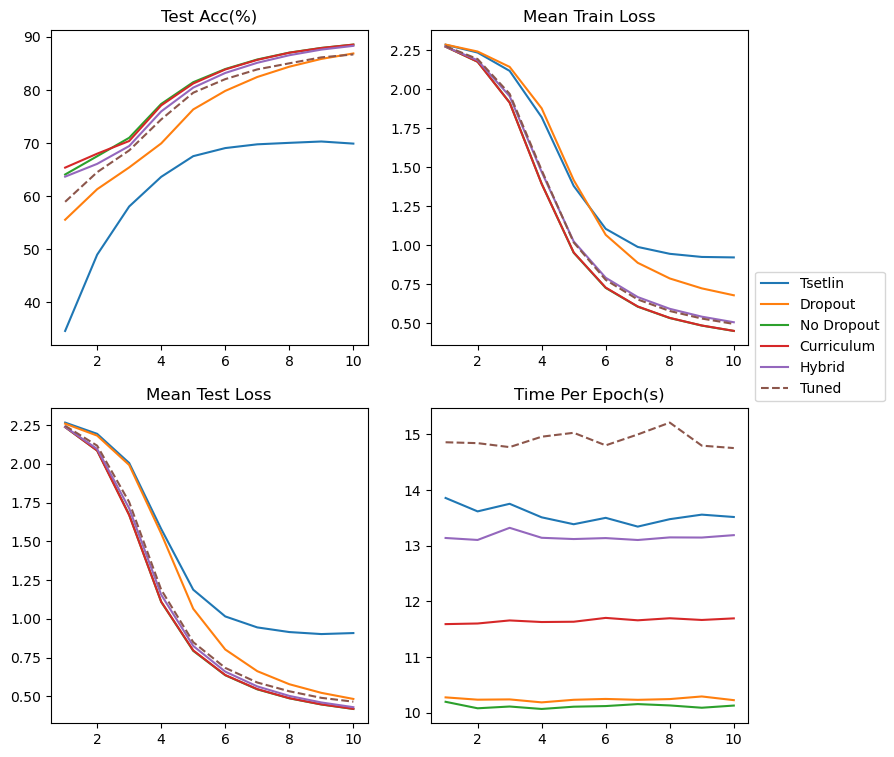

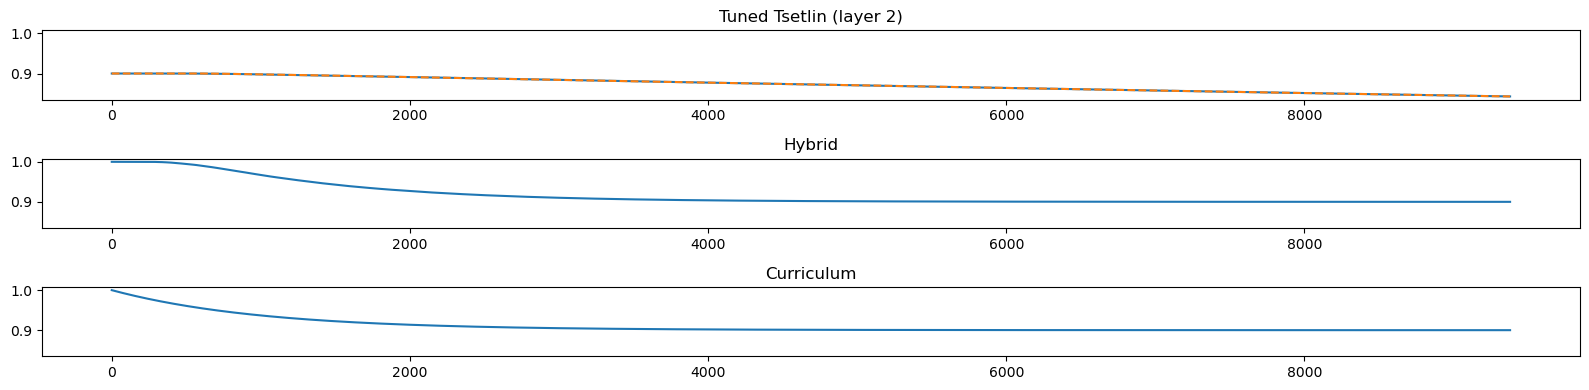

In [7]:
best = pd.read_csv(r"MNIST/2000 Model/MNIST_best_tset.csv")
bmean = get_avg(best, "Epoch")

x = np.arange(1,11)
fig,ax = plt.subplots(2,2,figsize=(9,9))


ax[0,0].plot(x,tmean['Test Acc(%)'],label="Tsetlin")
ax[0,0].plot(x,dmean['Test Acc(%)'],label="Dropout")
ax[0,0].plot(x,nmean['Test Acc(%)'],label="No Dropout")
ax[0,0].plot(x,cmean['Test Acc(%)'],label="Curriculum")
ax[0,0].plot(x,hmean['Test Acc(%)'],label="Hybrid")
ax[0,0].plot(x,bmean['Test Acc(%)'],label="Tuned", linestyle="--")
ax[0,0].set_title("Test Acc(%)")

ax[0,1].plot(x,tmean["Mean Train Loss"],label="Tsetlin")
ax[0,1].plot(x,dmean["Mean Train Loss"],label="Dropout")
ax[0,1].plot(x,nmean["Mean Train Loss"],label="No Dropout")
ax[0,1].plot(x,cmean["Mean Train Loss"],label="Curriculum")
ax[0,1].plot(x,hmean["Mean Train Loss"],label="Hybrid")
ax[0,1].plot(x,bmean["Mean Train Loss"],label="Tuned", linestyle="--")
ax[0,1].set_title("Mean Train Loss")

ax[1,0].plot(x,tmean["Mean Test Loss"],label="Tsetlin")
ax[1,0].plot(x,dmean['Mean Test Loss'],label="Dropout")
ax[1,0].plot(x,nmean['Mean Test Loss'],label="No Dropout")
ax[1,0].plot(x,cmean['Mean Test Loss'],label="Curriculum")
ax[1,0].plot(x,hmean['Mean Test Loss'],label="Hybrid")
ax[1,0].plot(x,bmean["Mean Test Loss"],label="Tuned", linestyle="--")
ax[1,0].set_title("Mean Test Loss")


ax[1,1].plot(x,tmean["Time Per Epoch(s)"],label="Tsetlin")
ax[1,1].plot(x,dmean["Time Per Epoch(s)"],label="Dropout")
ax[1,1].plot(x,nmean["Time Per Epoch(s)"],label="No Dropout")
ax[1,1].plot(x,cmean["Time Per Epoch(s)"],label="Curriculum")
ax[1,1].plot(x,hmean["Time Per Epoch(s)"],label="Hybrid")
ax[1,1].plot(x,bmean["Time Per Epoch(s)"],label="Tuned", linestyle="--")
ax[1,1].set_title("Time Per Epoch(s)")

plt.legend(loc="lower left",bbox_to_anchor=(1,1))
plt.show()

bprobs = pd.read_csv(r"MNIST/2000 Model/MNIST_best_tset_probs.csv")
temp = np.array([bprobs[bprobs.Run == i]["Keep Probability"] for i in range(10)])
bmean_prob = temp.mean(axis=0)


cprobs = [(1-0.9)*np.exp(-0.001*i)+0.9 for i in range(1,len(tmean_prob)+1)]

f2,a2 = plt.subplots(3,1,figsize=(16,4), sharey=True)

a2[0].plot(np.arange(len(bmean_prob)), bmean_prob)
a2[0].plot(np.arange(len(bmean_prob)),bprobs["Keep Probability"][:len(bmean_prob)],linestyle="--")
a2[0].set_title("Tuned Tsetlin (layer 2)")
a2[1].plot(np.arange(len(hmean_prob)),hmean_prob)
a2[1].set_title("Hybrid")
a2[2].plot(np.arange(len(hmean_prob)),cprobs)
a2[2].set_title("Curriculum")
plt.tight_layout()

The tuned hyperparameters really made a difference! However, the process still takes a longer time, which does make sense since there is extra math and being performed. Not sure why it took even longer than untuned....

Next question remains: How does it compare after many more epochs of training?

Here is the average of 10 150 epoch sessions:

In [10]:
tset150 = pd.read_csv(r"MNIST/2000 Model/MNISTTsetlin10x150.csv")
drop150 = pd.read_csv(r"MNIST/2000 Model/MNISTDrop10x150.csv")
nodrop150 = pd.read_csv(r"MNIST/2000 Model/MNISTNoDrop10x150.csv")
curr150 = pd.read_csv(r"MNIST/2000 Model/MNISTCurrDrop10x150.csv")
hybrid150 = pd.read_csv(r"MNIST/2000 Model/MNISTHybrid10x150.csv")

tavg150 = get_avg(tset150, "Epoch")
davg150 = get_avg(drop150, "Epoch")
navg150 = get_avg(nodrop150, "Epoch")
cavg150 = get_avg(curr150, "Epoch")
havg150 = get_avg(hybrid150, "Epoch")

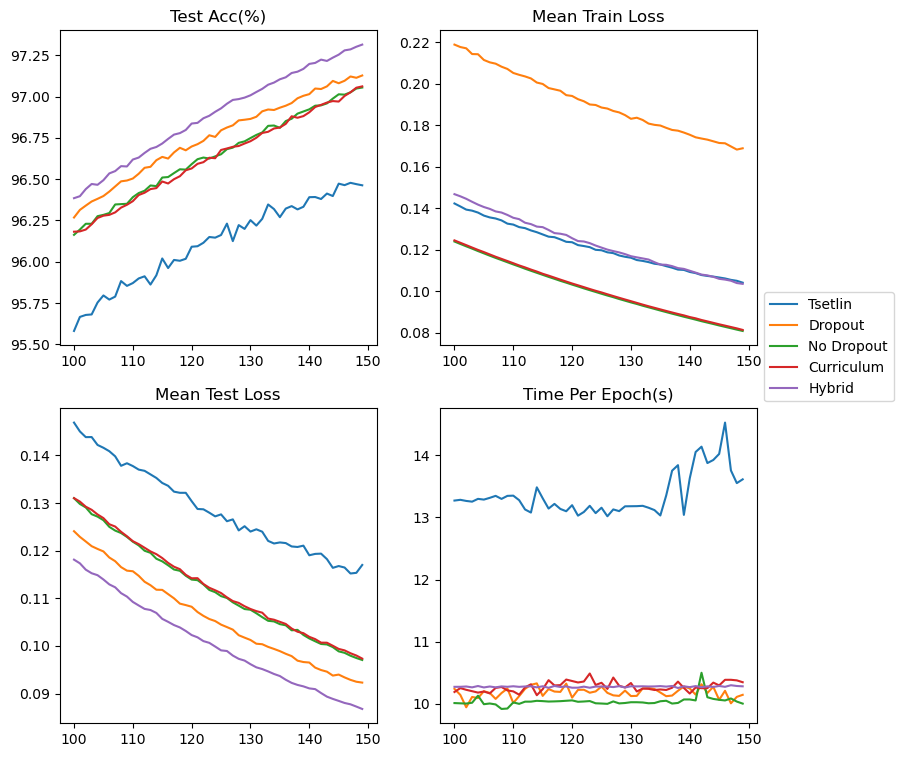

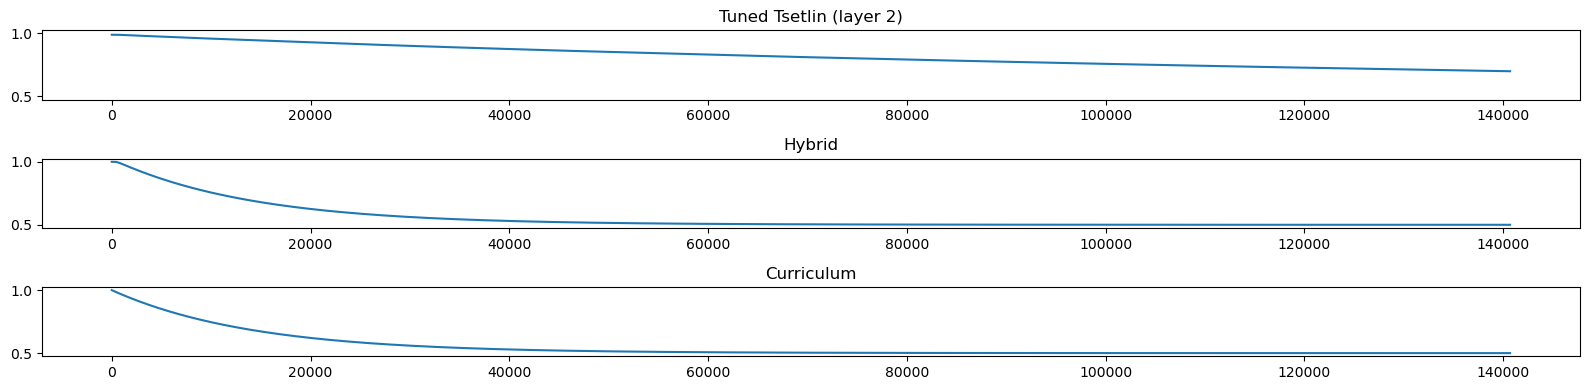

In [27]:
x = np.arange(100,150)
fig,ax = plt.subplots(2,2,figsize=(9,9))

ax[0,0].plot(x,tavg150['Test Acc(%)'][100:],label="Tsetlin")
ax[0,0].plot(x,davg150['Test Acc(%)'][100:],label="Dropout")
ax[0,0].plot(x,navg150['Test Acc(%)'][100:],label="No Dropout")
ax[0,0].plot(x,cavg150['Test Acc(%)'][100:],label="Curriculum")
ax[0,0].plot(x,havg150['Test Acc(%)'][100:],label="Hybrid")
ax[0,0].set_title("Test Acc(%)")


ax[0,1].plot(x,tavg150["Mean Train Loss"][100:],label="Tsetlin")
ax[0,1].plot(x,davg150["Mean Train Loss"][100:],label="Dropout")
ax[0,1].plot(x,navg150["Mean Train Loss"][100:],label="No Dropout")
ax[0,1].plot(x,cavg150["Mean Train Loss"][100:],label="Curriculum")
ax[0,1].plot(x,havg150["Mean Train Loss"][100:],label="Hybrid")
ax[0,1].set_title("Mean Train Loss")

ax[1,0].plot(x,tavg150["Mean Test Loss"][100:],label="Tsetlin")
ax[1,0].plot(x,davg150['Mean Test Loss'][100:],label="Dropout")
ax[1,0].plot(x,navg150['Mean Test Loss'][100:],label="No Dropout")
ax[1,0].plot(x,cavg150['Mean Test Loss'][100:],label="Curriculum")
ax[1,0].plot(x,havg150['Mean Test Loss'][100:],label="Hybrid")
ax[1,0].set_title("Mean Test Loss")


ax[1,1].plot(x,tavg150["Time Per Epoch(s)"][100:],label="Tsetlin")
ax[1,1].plot(x,davg150["Time Per Epoch(s)"][100:],label="Dropout")
ax[1,1].plot(x,navg150["Time Per Epoch(s)"][100:],label="No Dropout")
ax[1,1].plot(x,cavg150["Time Per Epoch(s)"][100:],label="Curriculum")
ax[1,1].plot(x,havg150["Time Per Epoch(s)"][100:],label="Hybrid")
ax[1,1].set_title("Time Per Epoch(s)")

plt.legend(loc="lower left",bbox_to_anchor=(1,1))
plt.show()



tprobs150 = pd.read_csv(r"MNIST\2000 Model\MNISTTsetlin10x150_probs.csv")
temp = np.array([tprobs150[tprobs150.Run == i]["Keep Probability"] for i in range(10)])
tmean_prob150 = temp.mean(axis=0)

hprobs150 = pd.read_csv(r"MNIST/2000 Model/MNISTHybrid10x150_probs.csv")
temp = np.array([hprobs150[hprobs150.Run == i]["Keep Probability"] for i in range(10)])
hmean_prob150 = temp.mean(axis=0)

cprobs = [(1-0.5)*np.exp(-10./(938*150)*i)+0.5 for i in range(1,len(tmean_prob150)+1)]

f2,a2 = plt.subplots(3,1,figsize=(16,4), sharey=True)

a2[0].plot(np.arange(len(tmean_prob150)), tmean_prob150)
a2[0].set_title("Tuned Tsetlin (layer 2)")
a2[1].plot(np.arange(len(hmean_prob150)),hmean_prob150)
a2[1].set_title("Hybrid")
a2[2].plot(np.arange(len(hmean_prob150)),cprobs)
a2[2].set_title("Curriculum")
plt.tight_layout()

With similar experiments to Morerio et al (with the exception of batch size), it appears that my "Tsetlin"-inspired dropout performs worse on unseen data than the other schema, while taking longer to train. I will see if this trend continues on other datasets!

However, one can see the Hybrid scheme performed best in this test suit, while in the same ballpark as the other "fast" approaches. This Hybrid model is based on Curriculum Dropout, but instead of decrementing the keep probability at every time (gradient update) step T, it only increases T if the batch was at least 50% correct, and decrementing it otherwise (as in the tsetlin model). This has the effect of slowing the descent of Curriculum Dropout's keep probability, while maintaining the overall shape. This can be seen in the graphs above. 
